# Wrap Up

Let's make the training script as concise as MNIST training in 1_Introduction

I will attempt this in two chapters
1. only using fastai
2. using [**niftiai**](https://github.com/codingfisch/niftiai) (**recommended**)!

*If you like niftiai, check out the [beginner](https://colab.research.google.com/drive/1LSI49-n94uAML8h0uBe8hoz9YUEIQ59z?usp=sharing) and [intermediate tutorial](https://colab.research.google.com/drive/1L1RX8OTzt5GCSatTNTH5aoHSd5hGHMOQ?usp=sharing)!*

## 🚨 Warning 🚨

This Notebook builds on 1_Introduction and the exercise of 2_Data_Exploration.

You have to run these Notebooks (if you didn't already) and mount your Google Drive to this Notebook via
```python
from google.colab import drive
drive.mount('/content/drive')
```
then you are ready to go!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Using only `fastai`
The central object of fastai is the `Learner` which requires `DataLoaders` (also a fastai object) and a PyTorch model
```python
from fastai.basics import Learner
...
learn = Learner(data, neural_net)
```
and enables training via

```python
learn.fit(n_epoch=5, lr=1e-3)
```
handeling the optimizer, gradients...all in the background 🤤

Given the exercise of 7_Training we already have a PyTorch model we can use


In [2]:
#@title Create `neural_net`
import torch.nn as nn

class NeuralNet(nn.Module):
  def __init__(self, kernel_size=3):
    super().__init__()
    self.conv1 = nn.Conv3d(1, 4, kernel_size=kernel_size)
    self.pool1 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv2 = nn.Conv3d(4, 16, kernel_size=kernel_size)
    self.pool2 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv3 = nn.Conv3d(16, 32, kernel_size=kernel_size)
    self.pool3 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv4 = nn.Conv3d(32, 1, kernel_size=kernel_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    return x

neural_net = NeuralNet()

so the only thing missing is `DataLoaders`.

Based on the instructions in ["Pytorch to fastai details"](https://docs.fast.ai/examples/migrating_pytorch_verbose.html) `DataLoaders` can be created using two PyTorch DataLoaders

```python
from fastai.data.core import DataLoaders

dls = DataLoaders(train_loader, test_loader)
```
one for training and one for testing/validation.

So first we create `train_dl` and `valid_dl` as we did in 7_Training



In [3]:
#@title Create `train_dl` and `valid_dl`
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import torch.nn.functional as F
PATH = '/content/drive/MyDrive/openneuro'

class NiftiDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, age_array, size=(128, 128, 128)):
        self.niftis = [self.load_nifti(fpath, size) for fpath in filepaths]
        self.ages = torch.from_numpy(age_array).float()

    def __len__(self):
        return len(self.niftis)

    def __getitem__(self, idx):
        return self.niftis[idx], self.ages[idx].float()

    @staticmethod
    def load_nifti(filepath, size):
      img = nib.load(filepath)
      img = nib.as_closest_canonical(img)
      x = img.get_fdata(dtype=np.float32)
      x = torch.from_numpy(x)
      x = x[None, None]  # added 2 dimensions using [None, None] to make it 5D
      x = F.interpolate(x, size=size)  # resized it to (1, 1, 128, 128, 128)
      return x[0]  # Removed one dimension using [0] because DataLoader will add one later


df = pd.read_csv(f'{PATH}/dataframe_after_preprocessing.csv', index_col=0)
valid_pids = [f'sub-01', 'sub-02', 'sub-03']

train_df = df[~df.index.isin(valid_pids)]
valid_df = df[df.index.isin(valid_pids)]
train_ds = NiftiDataset(train_df.t1w_filepath, age_array=train_df.age.values)
valid_ds = NiftiDataset(valid_df.t1w_filepath, age_array=valid_df.age.values)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=1, shuffle=False)

and then plug it in

In [4]:
from fastai.data.core import DataLoaders

dls = DataLoaders(train_dl, valid_dl)

Finally, we create the `Learner`...

In [5]:
from fastai.basics import Learner

learn = Learner(dls, neural_net)

AssertionError: Could not infer loss function from the data, please pass a loss function.

...oops `AssertionError: Could not infer loss function from the data, please pass a loss function` has to be sorted out first.

As the error tells you, `Learner` needs a loss function: the function which returns a low value if the neural net did good.

Looking at 7_Training the `error`

```python
...
error = (age - nifti_age) ** 2
...
```
looks like a good candidate.

We could create the function manually

```python
...
def mean_squared_error(age, nifti_age):
  return (age - nifti_age) ** 2

learn = Learner(dls, neural_net, loss_func=mean_squared_error)
...
```
but instead we will simply use the `mse` function provided by `fastai.basics`

In [6]:
from fastai.basics import mae, mse, Learner

learn = Learner(dls, neural_net, loss_func=mse, metrics=[mae])

I also snuck in the `mae` - mean absolute error - as an easy to understand `metric` which will be **shown for the validation samples**.

Finally, let's run the training

In [7]:
learn.fit(n_epoch=10, lr=1e-3)

[0, 1763.7210693359375, 591.702880859375, 24.242460250854492, '00:00']
[1, 934.8001098632812, 319.7236633300781, 17.80315589904785, '00:00']
[2, 577.5491333007812, 8.714856147766113, 2.1207523345947266, '00:00']
[3, 400.045166015625, 90.08155059814453, 9.213814735412598, '00:00']
[4, 286.1368408203125, 37.349674224853516, 5.405889987945557, '00:00']
[5, 212.7120819091797, 60.62760543823242, 7.325663089752197, '00:00']
[6, 161.24932861328125, 17.533323287963867, 3.669919967651367, '00:00']
[7, 126.3294677734375, 39.23625183105469, 5.533860683441162, '00:00']
[8, 97.75279998779297, 10.44398021697998, 2.1134071350097656, '00:00']
[9, 75.16870880126953, 7.705201625823975, 2.056166887283325, '00:00']


It trained successfully and we get a MAE of ~4 years in the validation samples 🎉

Of course you should not use this neural net in practice as it is only training with 13 and validated with 3 samples.

But you can use this script as a starting point and improve the results by
- using more data (OpenNeuro)
- using data augmentations
- using better models

In the next chapter we will touch on the last two approaches.

## 2. Using `niftiai`

`niftiai` enables writing training scripts as concise as MNIST training in 1_Introduction for neuroimaging data.




In [8]:
!pip install niftiai

One big advantage of `niftiai` is the `ImageDataLoaders3d` that allow you to create a fastai `DataLoaders` object via
```python
import pandas as pd
from fastai.basics import RegressionBlock
from niftiai import ImageDataLoaders3d

df = pd.read_csv(f'drive/MyDrive/openneuro/dataframe_after_preprocessing.csv', index_col=0)
dls = ImageDataLoaders3d.from_df(df, path='/', fn_col='zscore_filepath',
                                 label_col='age', y_block=RegressionBlock, bs=1)
```
only requiring the following input arguments
- `df`: DataFrame containing Nifti filenames and labels (e.g. age)
- `path`: A directory path which is prepended to all given filenames
- `fn_col`: Column of `df` containing filenames
- `label_col`: Column of `df` containing labels (e.g. age)
- `y_block`: Can be `RegressionBlock` or `CategoryBlock` (or `MultiCategoryBlock`)
- `bs`: Batch size

That makes our code a lot shorter compared to "1. using fastai" 🎉

You might wonder why I set `path='/'`. Well, this allows me to just use absolute filepaths in `fn_col`. If all Niftis would be directly in one directory I would use it as `path` and actually use a column with filenames as `fn_col`.

Let's try to run the code

In [9]:
import pandas as pd
from fastai.basics import RegressionBlock
from niftiai import ImageDataLoaders3d
from niftiai.transforms import Resize
from niftiai.augment import ChiNoise3d

df = pd.read_csv(f'drive/MyDrive/openneuro/dataframe_after_preprocessing.csv', index_col=0)
dls = ImageDataLoaders3d.from_df(df, path='/', fn_col='zscore_filepath',
                                 label_col='age', y_block=RegressionBlock, bs=2,
                                 item_tfms=Resize((128, 128, 128)),
                                 batch_tfms=ChiNoise3d(max_intensity=.5, p=1))

Nice, no error...despite me squeezing two more arguments in there to show you more capabilities:
- `item_tfms`: Data transformations (e.g. Resizing) that are applied to each single Nifti tensors
- `batch_tfms`: Data transformations (e.g. Augmentations) that are applied to each batch of Nifti tensors

Acutally, we have already written an `item_tfms` in the exercise of 6_Convolutional_Neural_Net: The resizing in `NiftiDataset`.

Resizing is almost always required since
- in many datasets Niftis have different shape
- batch size > 1 is used -> Niftis have to be the same shape to be stacked in one tensor
- the neural net only supports certain shapes
- our enemy 😈 `RuntimeError: CUDA out of memory` tells us that something (e.g. large Niftis) uses to much VRAM

<p>
<img src="https://media.licdn.com/dms/image/D5622AQFvCHYUPVUurA/feedshare-shrink_2048_1536/0/1681892789373?e=2147483647&v=beta&t=bUVho-842n1lkJJx-OlDHj_OXQM7ICSKqCeLEtleGkk" width=500/>
<figcaption>Taken from <a href="https://www.linkedin.com/posts/sallu-mandya_runtimeerror-cuda-error-out-of-memory-activity-7054369655980773376-InaI">https://www.linkedin.com/posts/sallu-mandya_runtimeerror-cuda-error-out-of-memory-activity-7054369655980773376-InaI</a></figcaption>
</p>


`batch_tfms` allow us to apply data augmentations such as `ChiNoise3d` which
1. artificially "increase the amount of data"
2. make the model prediction more robust with respect to the augmentation

We can (and should) use `dls.show_batch()` multiple times to visually check if the data looks right

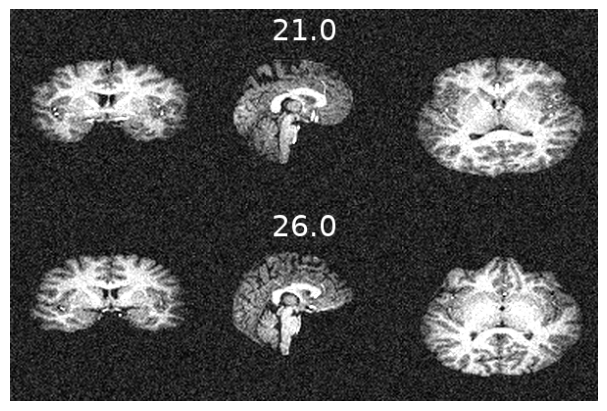

In [10]:
dls.show_batch()

We can see that the random noise introduced via `ChiNoise3d(max_intensity=.5, p=1)` is quite strong.

We could tinker with `max_intensity` and even add more [augmentations](https://github.com/codingfisch/niftiai/blob/main/niftiai/augment.py) but instead we use the default set of augmentations via

In [11]:
import pandas as pd
from fastai.basics import RegressionBlock
from niftiai import aug_transforms3d, ImageDataLoaders3d

df = pd.read_csv(f'drive/MyDrive/openneuro/dataframe_after_preprocessing.csv', index_col=0)
aug_tfms = aug_transforms3d()
dls = ImageDataLoaders3d.from_df(df, path='/', fn_col='zscore_filepath',
                                 label_col='age', y_block=RegressionBlock, bs=2,
                                 item_tfms=Resize(128), batch_tfms=aug_tfms)

with `aug_transforms3d` which returns a list of the following augmentations with reasonable strengths
- [`AffineWarp3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#affinewarp3dx-zoom-rotate-translate-shear-magnitude01)
  - combination of [`Warp3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#warp3dx-magnitude01)...
  - ...and affine transformations: [`Zoom3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#zoom3dx-zoom), [`Rotate3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#rotate3dx-rotate), [`Translate3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#translate3dx-translate) and [`Shear3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#shear3dx-shear)
- [`ChiNoise3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#chi_noise3dx-intensity05-dof3-set-dof2-for-rician-noise)
- [`BiasField3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#bias_field3dx-intensity2)
- [`Contrast3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#contrastx-lighting5)
- [`Ringing3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#ringing3dx-intensity5)
- [`Motion3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#motion3dx-intensity5)
- [`Ghosting3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#ghosting3dx-intensity5)
- [`Spike3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#spike3dx-intensity2)
- [`Downsample3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#downsample3dx-scale25-dim2)
- [`Flip3d`](https://github.com/codingfisch/mriaug?tab=readme-ov-file#flip3dx-dim0)

using the [mriaug package](https://github.com/codingfisch/mriaug)!

Let's see if it looks good

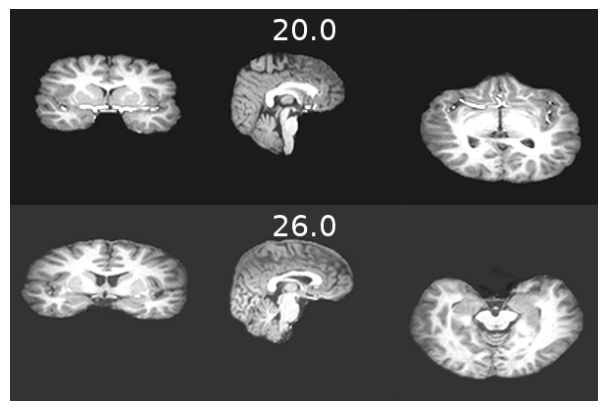

In [12]:
dls.show_batch()

Looks reasonable!

Now, we can finally train our `neural_net`

In [13]:
from fastai.basics import mae, mse, Learner

learn = Learner(dls, neural_net, loss_func=mse, metrics=[mae])
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,503.233276,386.595337,19.503901,00:09
1,337.207184,13.777871,3.061339,00:08
2,244.693878,7.291732,2.522773,00:06
3,193.624359,45.432804,6.273460,00:09
4,153.348618,10.092016,3.099834,00:06
5,122.235191,28.524115,4.346523,00:08
6,101.491531,13.386181,3.514097,00:06
7,87.668243,9.847766,3.000761,00:08
8,75.436356,12.098910,3.395829,00:07
9,65.132729,13.255680,3.519501,00:07


Wow, that worked very good...partly because I snuck `.fit_one_cycle` instead of `.fit` in there which applies a [clever learning rate policy](https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle).

Let's put it all together in one script!

In [ ]:
import pandas as pd
from fastai.basics import RegressionBlock
from niftiai import aug_transforms3d, ImageDataLoaders3d
from niftiai.models import TinyCNN3d
from niftiai.transforms import Resize

df = pd.read_csv(f'drive/MyDrive/openneuro/dataframe_after_preprocessing.csv', index_col=0)
aug_tfms = aug_transforms3d()
dls = ImageDataLoaders3d.from_df(df, path='/', fn_col='zscore_filepath',
                                 label_col='age', y_block=RegressionBlock, bs=2,
                                 item_tfms=Resize(128), batch_tfms=aug_tfms)
learn = Learner(dls, neural_net, loss_func=mse, metrics=[mae])
#learn = Learner(dls, TinyCNN3d(c_start=4), loss_func=mse, metrics=[mae])
learn.fit_one_cycle(10, 1e-3)
learn.get_preds()

We did it 🎉 We **trained a neural net with neuroimaging data in only 12 lines of code** 🎉

From here on out there is one very simple recipe to **make the neural net better: Scale it up!**

So, if you want to maximize performance [use more data and increase model size accordingly](https://arxiv.org/abs/2001.08361) like it is done for ChatGPT!

*Use a larger CNN by uncommenting the line with `TinyCNN3d(c_start=4)` and increase c_start*

**Final task 1**: In a binary classification task a model has to surpass at least a (balanced) accuracy of 50% to show its utility. What is the corresponding threshold for the MAE/MSE in regression tasks?

We can use a dummy regressor which always predicts the mean of the validation samples:

In [14]:
import numpy as np

ages = np.array([26., 20., 24.])
dummy_ages = np.array(3 * [ages.mean()])
dummy_mse = ((ages - dummy_ages) ** 2).mean()
dummy_mae = abs(ages - dummy_ages).mean()
print(dummy_mse, dummy_mae)

6.222222222222222 2.2222222222222228


Since the validation samples are of similar age predicting the mean age gives low metrics

These metrics are hard to beat pointing at the first mistake we did:
- Using a validation (and training) sample with a too small age range

**Final task 2**: What could be pitfalls regarding reliable validation of neuroimaging model performance?

- **Scanner effects**: Validation (and training) with **data coming from only one MRI scanner**
- **Demographic effects**: Age range, sex, ethnicity...in **data sample should be as heterogeneous as in a realistic use case**
- Be aware of potential **biases**: **Training with MRIs from old male and young female** participants will likely result in **males being predicted older** than females for new data (use case)